In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import roboflow
import supervision
import transformers
import pytorch_lightning

print(
    "roboflow:", roboflow.__version__,
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Tue_May_27_02:24:01_Pacific_Daylight_Time_2025
Cuda compilation tools, release 12.9, V12.9.86
Build cuda_12.9.r12.9/compiler.36037853_0
torch:  2.7 ; cuda:  cu128
roboflow: 1.2.1 ; supervision: 0.25.1 ; transformers: 4.53.2 ; pytorch_lightning: 2.5.2


In [2]:
!pip install rfdetr


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import torch
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="J1rWUvuwvKwOyLI5ooEK")
project = rf.workspace("sanjana-kazi-supti-ymhu2").project("final-1yr0d-wo5ot")
version = project.version(1)
dataset = version.download("coco")


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


loading Roboflow workspace...
loading Roboflow project...


### Install ultralytics supervision and Roboflow. Then check for the CUDA

In [5]:
!pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.164  Python-3.13.3 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
Setup complete  (16 CPUs, 15.4 GB RAM, 42.1/165.0 GB disk)


In [6]:
!pip install pycocotools tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import os
import shutil
import json
from pathlib import Path
import yaml
from ultralytics import YOLO

## Create COCO data loaders

In [8]:
import os
import torch
import torchvision
from pathlib import Path
from transformers import DetrImageProcessor  # Or your desired processor

# ----------------------------------------------------------------------------
# Set dataset location and annotation name
# ----------------------------------------------------------------------------
DATASET_LOCATION = Path(r"D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1")  # Use raw string to avoid issues
ANNOTATION_FILE_NAME = "_annotations.coco.json"

TRAIN_DIRECTORY = DATASET_LOCATION / "train"
VAL_DIRECTORY   = DATASET_LOCATION / "valid"
TEST_DIRECTORY  = DATASET_LOCATION / "test"

# ----------------------------------------------------------------------------
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        image_processor,
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    image_processor=image_processor,
    train=True)
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    image_processor=image_processor,
    train=False)
TEST_DATASET = CocoDetection(
    image_directory_path=TEST_DIRECTORY,
    image_processor=image_processor,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of test examples:", len(TEST_DATASET))


loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
Number of training examples: 3957
Number of validation examples: 165
Number of test examples: 165


Image #2481


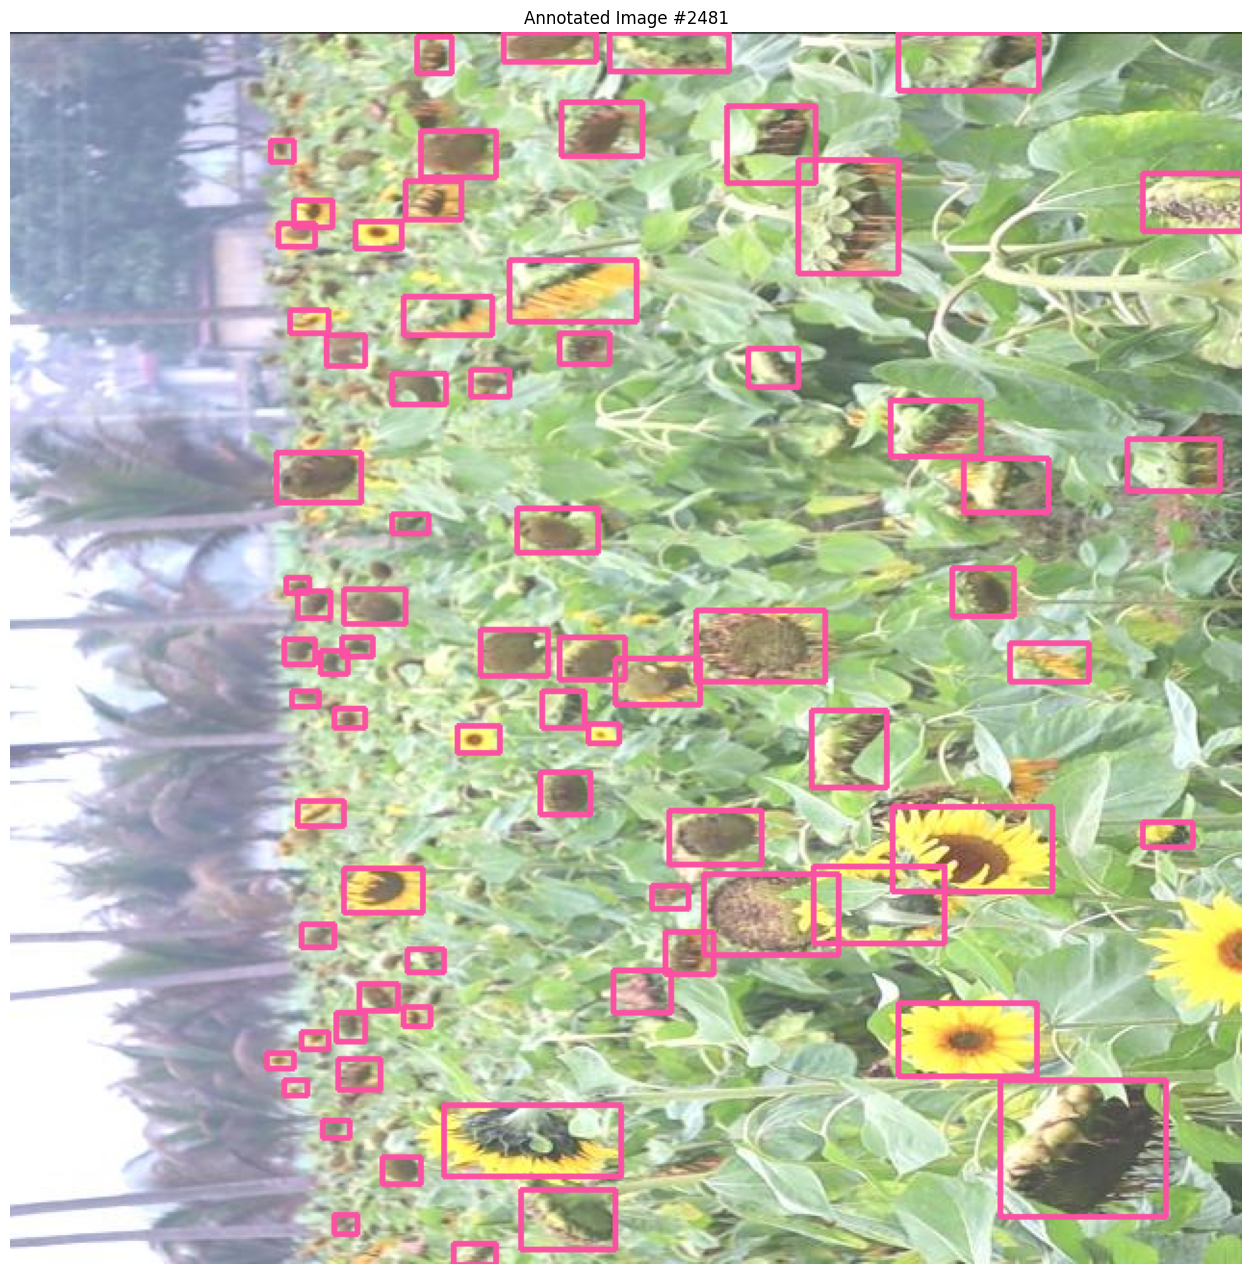

In [9]:
import os
import random
import cv2
import numpy as np
import supervision as sv
from supervision import Detections, BoxAnnotator
import matplotlib.pyplot as plt

# Select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print(f'Image #{image_id}')

# Load image and annotations
image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib display

# Manually convert COCO annotations to supervision.Detections
xyxy = []
class_ids = []
confidences = []

for ann in annotations:
    x, y, w, h = ann['bbox']
    xyxy.append([x, y, x + w, y + h])
    class_ids.append(ann['category_id'] - 1)  # COCO class_id is 1-based, convert to 0-based
    confidences.append(1.0)  # Dummy confidence for ground truth

detections = Detections(
    xyxy=np.array(xyxy, dtype=np.float32),
    class_id=np.array(class_ids),
    confidence=np.array(confidences)
)

# Prepare labels mapping class_id -> class name
categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k, v in categories.items()}

labels = [
    id2label[class_id + 1]  # convert back to COCO 1-based for label lookup
    for class_id in detections.class_id
]

# Annotate image with bounding boxes and labels
box_annotator = BoxAnnotator()
frame = box_annotator.annotate(scene=image.copy(), detections=detections)

# Display annotated image using matplotlib
plt.figure(figsize=(16, 16))
plt.imshow(frame)
plt.axis('off')
plt.title(f"Annotated Image #{image_id}")
plt.show()


## Train an RF-DETR Model

In [10]:
# from rfdetr import RFDETRMedium

# model = RFDETRMedium()

# model.train(dataset_dir=dataset.location, epochs=10, batch_size=8, grad_accum_steps=2, lr=1e-4, output_dir="D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-model", save_model=True, save_interval=1, save_best_only=True, use_amp=True, device=DEVICE)

In [11]:
import torch
from rfdetr import RFDETRNano

# 1. Select device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# 2. Load RF-DETR nano variant
model = RFDETRNano()

# 3. Set training parameters
model.train(
    dataset_dir="D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1",  # Path to your COCO-format dataset
    epochs=20,                        # Set according to training needs
    batch_size=4,                    # Suitable for 'nano' variant and limited VRAM
    grad_accum_steps=3,             # Accumulates gradients over 4 steps before updating
    lr=1e-4,                         # Typical starting learning rate
    output_dir="D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-nano",  # Output save dir
    save_model=True,                 # Save model after epochs
    save_interval=1,                 # Save after every epoch
    save_best_only=True,             # Only save if performance improves
    use_amp=True if DEVICE == "cuda" else False,  # Mixed precision for GPU
    device=DEVICE                    # CPU or CUDA
)





Using device: cuda
Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


num_classes mismatch: model has 90 classes, but your dataset has 2 classes
reinitializing your detection head with 2 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-nano' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=2, grad_accum_steps=3, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=4, weight_decay=0.0001, epochs=20, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-nano.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=

Epoch: [0]  [  0/329]  eta: 1:35:51  lr: 0.000100  class_error: 3.73  loss: 10.1824 (10.1824)  loss_ce: 0.4811 (0.4811)  loss_bbox: 0.9689 (0.9689)  loss_giou: 1.8335 (1.8335)  loss_ce_0: 0.4402 (0.4402)  loss_bbox_0: 1.1079 (1.1079)  loss_giou_0: 1.8749 (1.8749)  loss_ce_enc: 0.4494 (0.4494)  loss_bbox_enc: 1.1393 (1.1393)  loss_giou_enc: 1.8873 (1.8873)  loss_ce_unscaled: 0.4811 (0.4811)  class_error_unscaled: 3.7312 (3.7312)  loss_bbox_unscaled: 0.1938 (0.1938)  loss_giou_unscaled: 0.9168 (0.9168)  cardinality_error_unscaled: 142.0000 (142.0000)  loss_ce_0_unscaled: 0.4402 (0.4402)  loss_bbox_0_unscaled: 0.2216 (0.2216)  loss_giou_0_unscaled: 0.9374 (0.9374)  cardinality_error_0_unscaled: 1917.7500 (1917.7500)  loss_ce_enc_unscaled: 0.4494 (0.4494)  loss_bbox_enc_unscaled: 0.2279 (0.2279)  loss_giou_enc_unscaled: 0.9437 (0.9437)  cardinality_error_enc_unscaled: 1250.2500 (1250.2500)  time: 17.4820  data: 14.3219  max mem: 5394
Epoch: [0]  [ 10/329]  eta: 0:15:36  lr: 0.000100  class

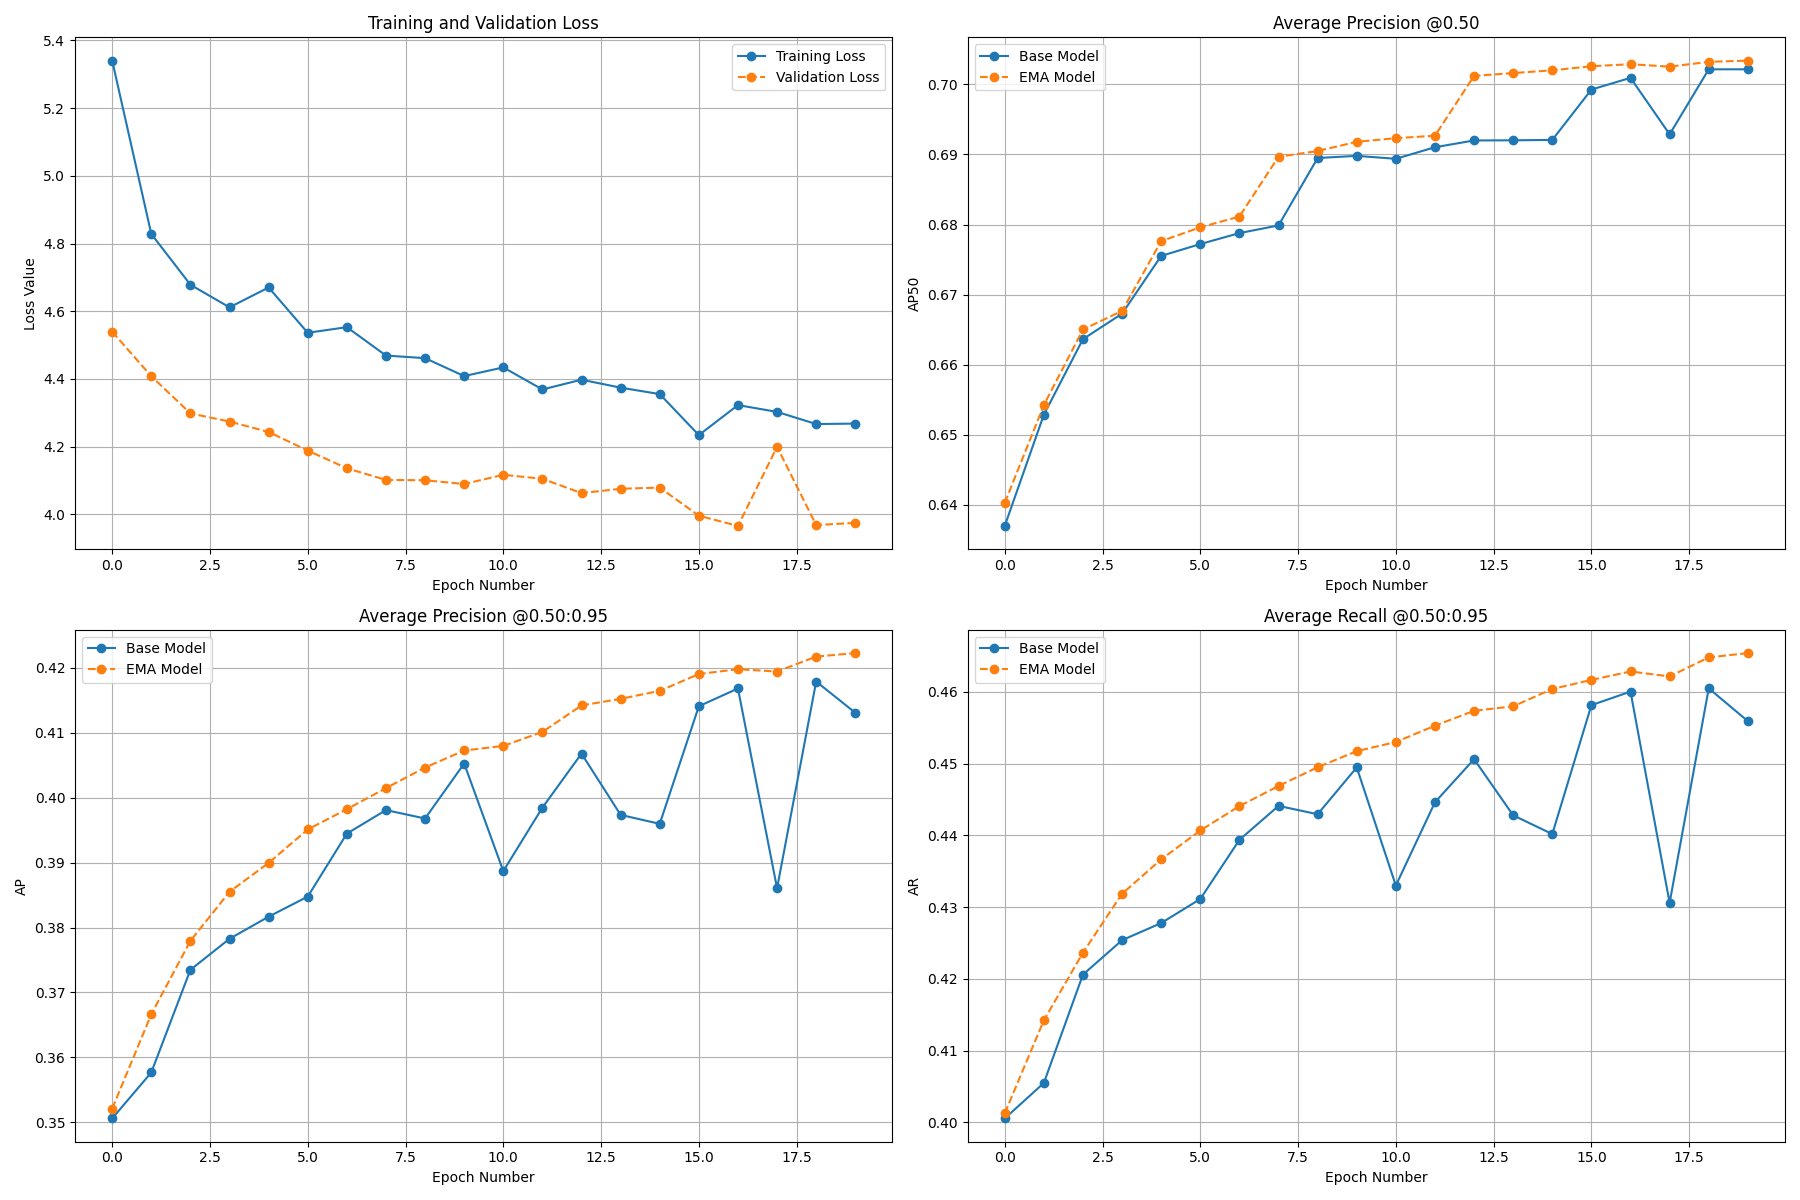

In [3]:
from PIL import Image

Image.open("D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-nano/metrics_plot.png")

## Inference

In [12]:
from rfdetr import RFDETRNano

model = RFDETRNano(pretrain_weights="D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-nano/checkpoint_best_total.pth")

detections = model.predict("D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1/test/MVI_9976-MP4_frame15_jpg.rf.8daac343cef073d1a116333e2e1ee2e9.jpg")
detections

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


num_classes mismatch: pretrain weights has 1 classes, but your model has 90 classes
reinitializing detection head with 1 classes
Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


Loading pretrain weights


Detections(xyxy=array([[     504.41,      133.47,      570.93,      245.01],
       [     127.75,      75.637,      179.21,      167.49],
       [     234.89,      89.629,      279.68,      168.85],
       [     214.69,      178.84,      264.72,      254.39],
       [     311.38,      260.17,      354.67,      330.87],
       [     130.68,      196.77,      180.43,      291.57],
       [     522.44,       54.63,      570.06,       131.5],
       [     141.18,      356.77,      186.89,      430.16],
       [     598.09,      106.29,      626.82,      156.53],
       [     415.14,      269.88,      462.89,      351.27],
       [   -0.14108,      187.52,      40.544,      274.58],
       [     184.49,      477.52,      221.77,      553.24],
       [      468.6,      81.822,      492.18,      119.52],
       [     370.29,       120.3,      401.02,      168.39],
       [     454.14,      132.87,      503.38,      200.41],
       [     184.17,      93.087,       202.4,      123.82],
       [

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


num_classes mismatch: pretrain weights has 1 classes, but your model has 90 classes
reinitializing detection head with 1 classes
Model is not optimized for inference. Latency may be higher than expected. You can optimize the model for inference by calling model.optimize_for_inference().


Loading pretrain weights


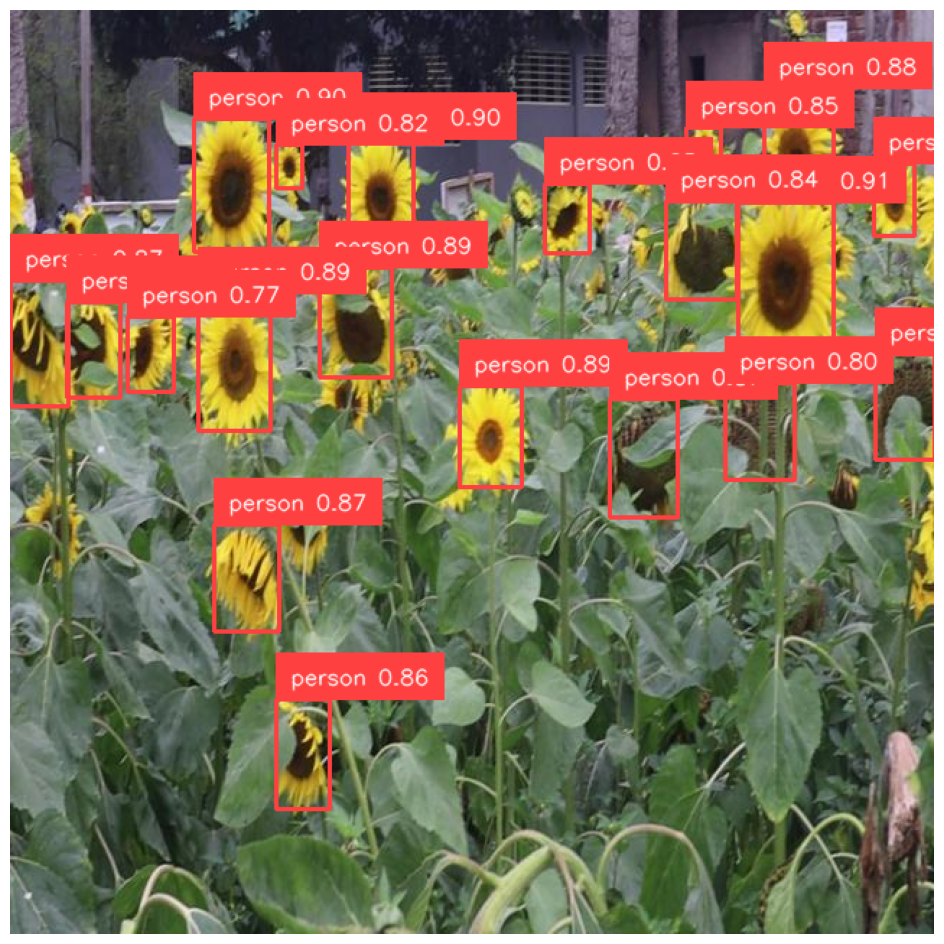

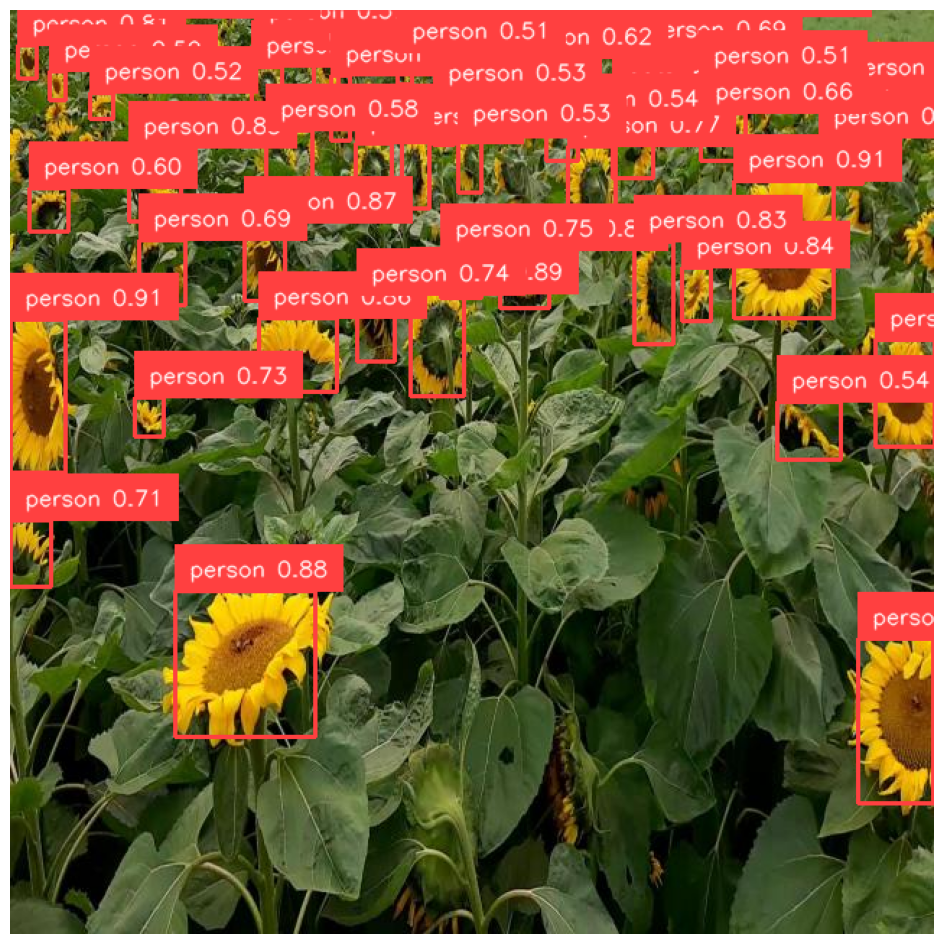

In [13]:
import io
import requests
import supervision as sv
from PIL import Image
from rfdetr import RFDETRBase
from rfdetr.util.coco_classes import COCO_CLASSES

model = RFDETRNano(pretrain_weights="D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/DETR-model/DETR_rfdetr-nano/checkpoint_best_total.pth")

urls = [
    "D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1/test/MVI_9976-MP4_frame15_jpg.rf.8daac343cef073d1a116333e2e1ee2e9.jpg",
    "D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1/test/20240206_132004-mp4_frame41_jpg.rf.cec8877ba689686b88de610b04185376.jpg"
]

images = [Image.open(url) for url in urls]

detections_list = model.predict(images, threshold=0.5)

for image, detections in zip(images, detections_list):
    labels = [
        f"{COCO_CLASSES[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    annotated_image = image.copy()
    annotated_image = sv.BoxAnnotator().annotate(annotated_image, detections)
    annotated_image = sv.LabelAnnotator().annotate(annotated_image, detections, labels)

    sv.plot_image(annotated_image)

## Run Inference with Fine-tuned RF-DETR Model

In [1]:
import supervision as sv

DIR = "D:/EWU/10th Semester/CSE475/LABS/ASSIGNMENT/Final-1"
ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{DIR}/test",
    annotations_path=f"{DIR}/test/_annotations.coco.json",
)

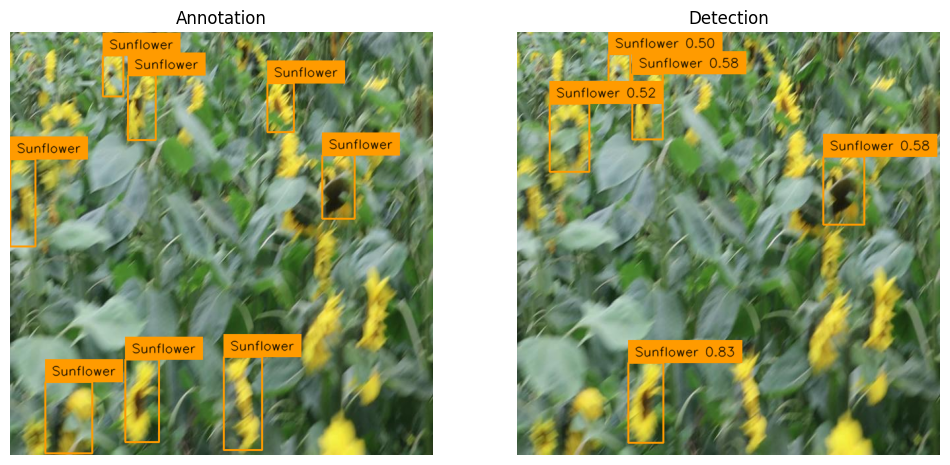

In [15]:
from rfdetr import RFDETRNano
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

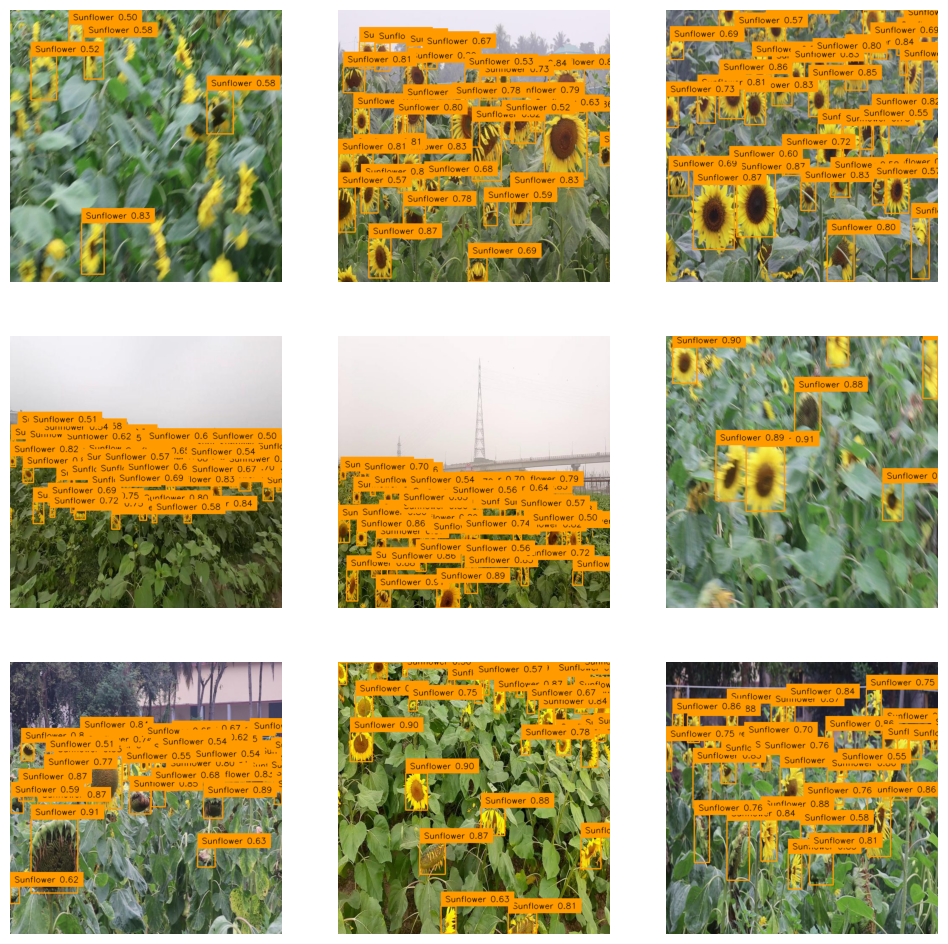

In [16]:
import supervision as sv
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
    color = sv.ColorPalette.from_hex([
        "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
        "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
    ])

    bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        color=color,
        text_color=sv.Color.BLACK,
        text_scale=text_scale)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

## Evaluate Fine-tuned RF-DETR Model

In [17]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

100%|██████████| 165/165 [00:05<00:00, 30.24it/s]


MeanAveragePrecisionResult:
Metric target: MetricTarget.BOXES
Class agnostic: False
mAP @ 50:95: 0.3914
mAP @ 50:    0.6222
mAP @ 75:    0.4400
mAP scores: [    0.62218     0.62008     0.59844     0.56474     0.51746     0.44001     0.31934     0.17338    0.048018    0.010242]
IoU thresh: [        0.5        0.55         0.6        0.65         0.7        0.75         0.8        0.85         0.9        0.95]
AP per class:
  1: [    0.62218     0.62008     0.59844     0.56474     0.51746     0.44001     0.31934     0.17338    0.048018    0.010242]

Small objects:
  MeanAveragePrecisionResult:
  Metric target: MetricTarget.BOXES
  Class agnostic: False
  mAP @ 50:95: 0.2794
  mAP @ 50:    0.4928
  mAP @ 75:    0.2878
  mAP scores: [    0.49276     0.48147     0.45923      0.4234     0.37364     0.28777     0.17427     0.07342    0.018305    0.009901]
  IoU thresh: [        0.5        0.55         0.6        0.65         0.7        0.75         0.8        0.85         0.9        0.95]
  A